In [2]:
import dask.dataframe as dd#similar to pandas

import pandas as pd#pandas to create small dataframes 

# unix time: https://www.unixtimestamp.com/
import datetime #Convert to unix time

import time #Convert to unix time

# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays

from matplotlib import rcParams#Size of plots  

import matplotlib.pylab as plt
import seaborn as sns#Plots

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os

import xgboost as xgb

# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
test1 = pd.read_csv('/Users/jinsu/Desktop/vscode/taxi+_zone_lookup.csv')

In [11]:
test1.head(5)
find_row = test1.loc[(test1['Borough'] == 'Manhattan')]
# find_row
manhattan_num = find_row['LocationID']
print(manhattan_num)
print(len(manhattan_num))

3        4
11      12
12      13
23      24
40      41
      ... 
245    246
248    249
260    261
261    262
262    263
Name: LocationID, Length: 69, dtype: int64
69


In [25]:
month = dd.read_parquet('/Users/jinsu/Desktop/vscode/yellow_tripdata_2020-01.parquet')
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,None
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,None
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,None
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,None
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,None


In [26]:
#The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert thiss sting to python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    s = np.datetime_as_string(s, unit='s')
    s = s.replace('T', ' ')

    return time.mktime(datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S').timetuple())



# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','PULocationID','DOLocationID','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

frame_with_durations = return_with_trip_times(month)
print(frame_with_durations.head())

   passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0              1.0            1.2           238           239         11.27   
1              1.0            1.2           239           238         12.30   
2              1.0            0.6           238           238         10.80   
3              1.0            0.8           238           151          8.16   
4              1.0            0.0           193           193          4.80   

   trip_times  pickup_times      Speed  
0    4.800000  1.577806e+09  15.000000  
1    7.416667  1.577807e+09   9.707865  
2    6.183333  1.577807e+09   5.822102  
3    4.850000  1.577808e+09   9.896907  
4    2.300000  1.577805e+09   0.000000  


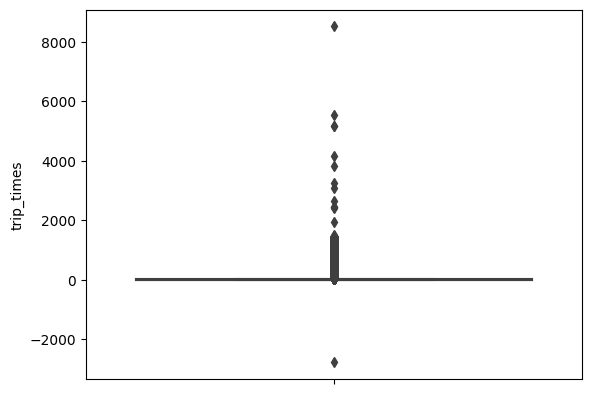

In [27]:
sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show()

In [28]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -2770.366666666667
10 percentile value is 3.9833333333333334
20 percentile value is 5.616666666666666
30 percentile value is 7.133333333333334
40 percentile value is 8.716666666666667
50 percentile value is 10.483333333333333
60 percentile value is 12.55
70 percentile value is 15.166666666666666
80 percentile value is 18.9
90 percentile value is 25.616666666666667
100 percentile value is  8525.116666666667


In [29]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 25.616666666666667
91 percentile value is 26.716666666666665
92 percentile value is 27.95
93 percentile value is 29.333333333333332
94 percentile value is 31.0
95 percentile value is 33.05
96 percentile value is 35.65
97 percentile value is 39.06666666666667
98 percentile value is 44.15
99 percentile value is 53.43333333333333
100 percentile value is  8525.116666666667


In [30]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

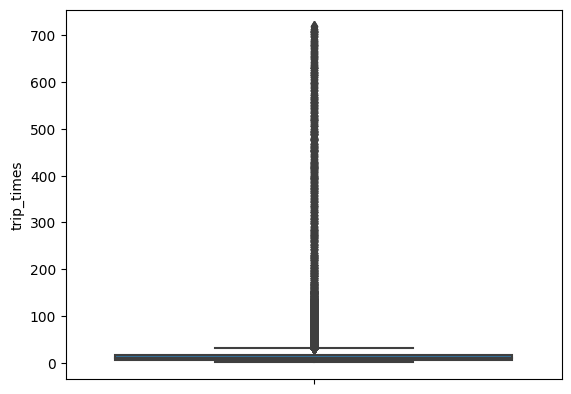

In [31]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show()

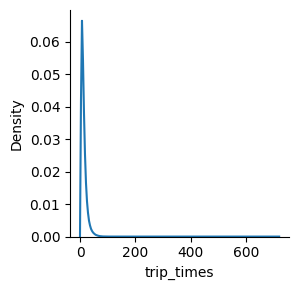

In [32]:
#pdf of trip-times after removing the outliers #size=6인거 지웠는데 무엇을 의미..?
sns.FacetGrid(frame_with_durations_modified) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend()
plt.show()

In [33]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

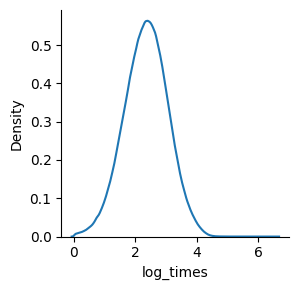

In [34]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified) \
      .map(sns.kdeplot,"log_times") \
      .add_legend()
plt.show()

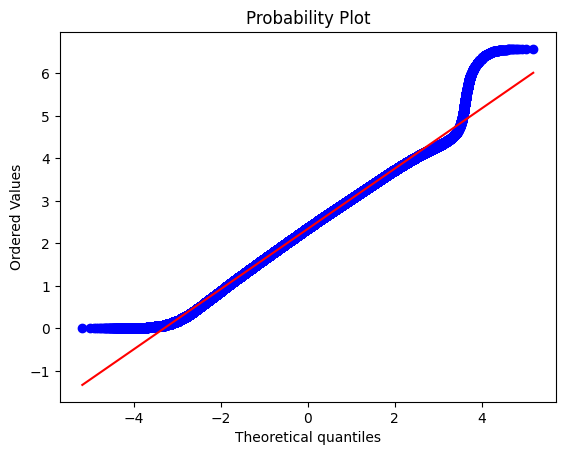

In [35]:
#Q-Q plot for checking if trip-times is log-normal
import scipy
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

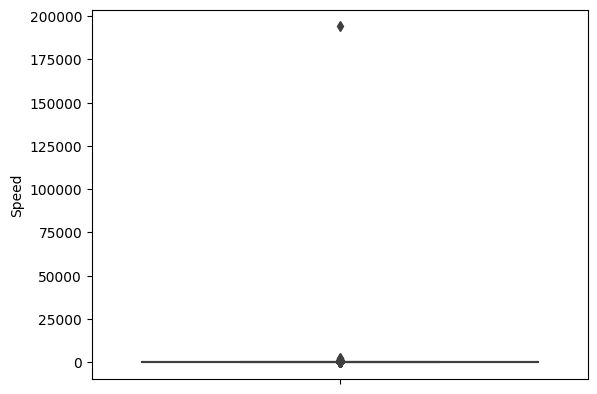

In [36]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [37]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -47.475
10 percentile value is 6.022304832713755
20 percentile value is 7.278688524590164
30 percentile value is 8.270270270270268
40 percentile value is 9.204545454545455
50 percentile value is 10.182136602451838
60 percentile value is 11.314285714285713
70 percentile value is 12.779999999999998
80 percentile value is 15.04017139796465
90 percentile value is 19.782372143634383
100 percentile value is  194067.75692307693


In [38]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 19.782372143634383
91 percentile value is 20.59259259259259
92 percentile value is 21.5
93 percentile value is 22.538860103626945
94 percentile value is 23.727272727272727
95 percentile value is 25.11917098445596
96 percentile value is 26.804758572428273
97 percentile value is 28.989858012170387
98 percentile value is 31.898734177215193
99 percentile value is 36.2608695652174
100 percentile value is  194067.75692307693


In [39]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 36.2608695652174
99.1 percentile value is 36.86440677966101
99.2 percentile value is 37.49480968858131
99.3 percentile value is 38.204081632653065
99.4 percentile value is 39.0
99.5 percentile value is 39.884892086330936
99.6 percentile value is 40.91493924231594
99.7 percentile value is 42.1978021978022
99.8 percentile value is 43.83673469387755
99.9 percentile value is 46.4
100 percentile value is  194067.75692307693


In [40]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<46.5)]

In [41]:
#avg.speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

11.806981398093967

# trip distance

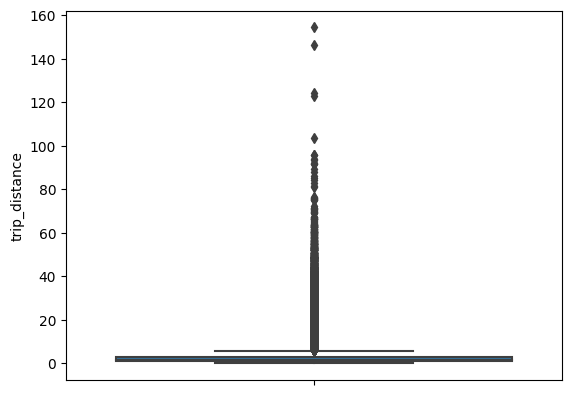

In [42]:
sns.boxplot(y="trip_distance", data=frame_with_durations_modified)
plt.show()

In [43]:
for i in range(0, 100, 10):
    var = frame_with_durations_modified['trip_distance'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])

0 percentile value is 0.01
10 percentile value is 0.64
20 percentile value is 0.88
30 percentile value is 1.1
40 percentile value is 1.32
50 percentile value is 1.61
60 percentile value is 2.0
70 percentile value is 2.54
80 percentile value is 3.56
90 percentile value is 6.68
100 percentile value is 154.45


In [44]:
for i in range(90, 100):
    var = frame_with_durations_modified['trip_distance'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])

90 percentile value is 6.68
91 percentile value is 7.3
92 percentile value is 8.04
93 percentile value is 8.83
94 percentile value is 9.7
95 percentile value is 10.79
96 percentile value is 12.41
97 percentile value is 15.53
98 percentile value is 17.57
99 percentile value is 19.05
100 percentile value is 154.45


In [45]:
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 19.05
99.1 percentile value is 19.29
99.2 percentile value is 19.53
99.3 percentile value is 19.84
99.4 percentile value is 20.2
99.5 percentile value is 20.6
99.6 percentile value is 21.07
99.7 percentile value is 21.67
99.8 percentile value is 22.9
99.9 percentile value is 26.7
100 percentile value is  154.45


In [46]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<27)]

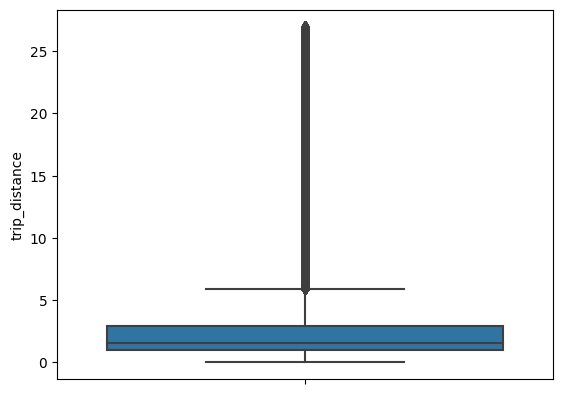

In [47]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

# total fare

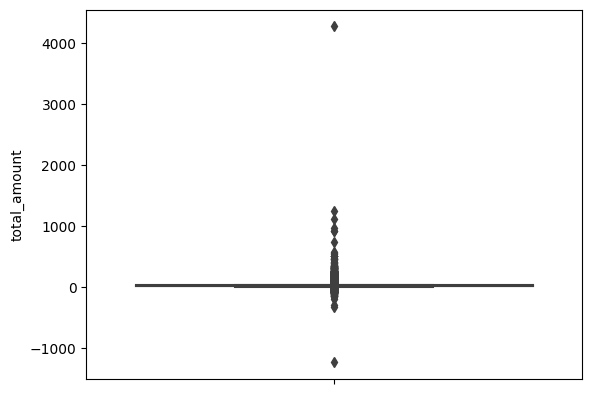

In [48]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [49]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -1242.3
10 percentile value is 9.3
20 percentile value is 10.56
30 percentile value is 11.76
40 percentile value is 12.96
50 percentile value is 14.3
60 percentile value is 15.96
70 percentile value is 18.3
80 percentile value is 21.95
90 percentile value is 31.31
100 percentile value is  4268.3


In [50]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 31.31
91 percentile value is 33.36
92 percentile value is 36.3
93 percentile value is 39.45
94 percentile value is 43.25
95 percentile value is 47.42
96 percentile value is 53.15
97 percentile value is 61.42
98 percentile value is 67.56
99 percentile value is 73.7
100 percentile value is  4268.3


In [51]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 73.7
99.1 percentile value is 73.7
99.2 percentile value is 74.9
99.3 percentile value is 76.77
99.4 percentile value is 76.92
99.5 percentile value is 79.1
99.6 percentile value is 79.42
99.7 percentile value is 82.4
99.8 percentile value is 89.55
99.9 percentile value is 102.06
100 percentile value is  4268.3


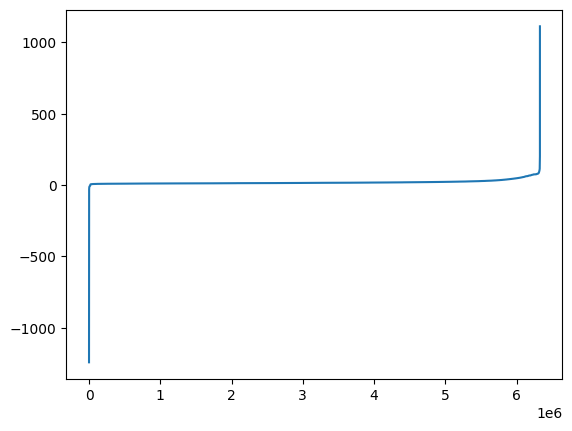

In [52]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.show()

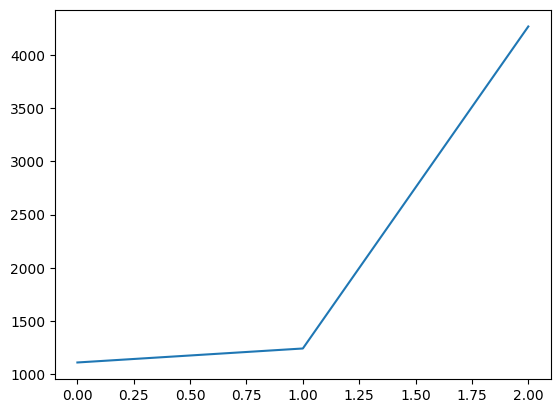

In [53]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

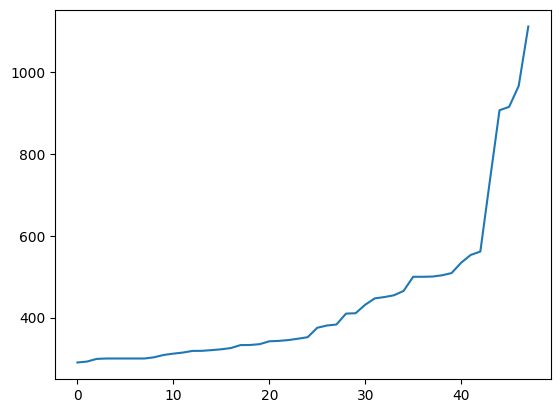

In [54]:
#now looking at values not including the last two points we again find a drastic increase at around 1000 fare value
# we plot last 50 values excluding last two values
plt.plot(var[-50:-2])
plt.show()

In [55]:
# 1. 이상한 시간
# 2. 이상한 속도
# 3. 이상한 거리
# 4. 이상한 비용
# 5. 이상한 팁
def remove_outliers(new_frame):
    a = new_frame.shape[0]
    print("총 데이터 수 = ", a)

    # 시간
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 120)]
    c = temp_frame.shape[0]
    print ("시간 튀는 값의 개수:",(a-c))
    
    # 거리
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 30)]
    d = temp_frame.shape[0]
    print ("거리 튀는 값의 개수:",(a-d))

    # 속도
    temp_frame = new_frame[(new_frame.Speed < 50) & (new_frame.Speed > 0)]
    e = temp_frame.shape[0]
    print ("속도 튀는 값의 개수",(a-e))

    # 비용
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("비용 튀는 값의 개수:",(a-f))

    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 30)]
    new_frame = new_frame[(new_frame.Speed < 50) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]

    print("전체 삭제 된 데이터 수", a-new_frame.shape[0])
    print("---")
    return new_frame

In [56]:
print("2020-01 데이터 제거 현황")
print("---")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("튀는 값 제거하고 남은 비율", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

2020-01 데이터 제거 현황
---
총 데이터 수 =  6405008
시간 튀는 값의 개수: 18599
거리 튀는 값의 개수: 73552
속도 튀는 값의 개수 78815
비용 튀는 값의 개수: 21182
전체 삭제 된 데이터 수 112078
---
튀는 값 제거하고 남은 비율 0.982501505072281


In [57]:
#Refer:https://www.unixtimestamp.com/
# 1577804400 : 2020-01-01 00:00:00 
# 1580482800 : 2020-02-01 00:00:00 
# 1582988400 : 2020-03-01 00:00:00
# 1585666800 : 2020-04-01 00:00:00 
# 1588258800 : 2020-05-01 00:00:00 
# 1590937200 : 2020-06-01 00:00:00

# 1609426800 : 2021-01-01 00:00:00 
# 1612105200 : 2021-02-01 00:00:00 
# 1614524400 : 2021-03-01 00:00:00
# 1617202800 : 2021-04-01 00:00:00 
# 1619794800 : 2021-05-01 00:00:00 
# 1622473200 : 2021-06-01 00:00:00
def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1577804400,1580482800,1582988400,1585666800,1588258800,1590937200],\
                    [1609426800,1612137600,1614524400,1617202800,1619794800,1622473200]]
    
    start_pickup_unix=unix_times[year-2020][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]

    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [58]:
jan_2020_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2020)

In [59]:
jan_2020_groupby = jan_2020_frame[['PULocationID', 'pickup_bins', 'trip_distance']].groupby(['PULocationID', 'pickup_bins']).count()

In [60]:
jan_2020_frame.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,trip_times,pickup_times,Speed,pickup_bins
0,1.0,1.20,238,239,11.27,4.800000,1.577806e+09,15.000000,35
1,1.0,1.20,239,238,12.30,7.416667,1.577807e+09,9.707865,36
2,1.0,0.60,238,238,10.80,6.183333,1.577807e+09,5.822102,37
3,1.0,0.80,238,151,8.16,4.850000,1.577808e+09,9.896907,38
5,1.0,0.03,7,193,3.80,0.883333,1.577805e+09,2.037736,33


In [61]:
jan_2020_groupby.head()

trip_distance
PULocationID pickup_bins               
1            118                      1
             126                      1
             137                      1
             217                      1
             218                      1

In [62]:
# upto now we cleaned data and prepared data for the month 2020,

# now do the same operations for months Jan, Feb, March of 2021
# 1. get the dataframe which inlcudes only required colums
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point
# 6. add pickup_bin (index of 10min intravel to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickuo_bin'

# Data Preparation for the months of Jan,Feb and March 2021
def datapreparation(month,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['PULocationID', 'pickup_bins', 'trip_distance']].groupby(['PULocationID', 'pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
month_jan_2021 = dd.read_parquet('/Users/jinsu/Desktop/vscode/yellow_tripdata_2021-01.parquet')
month_feb_2021 = dd.read_parquet('/Users/jinsu/Desktop/vscode/yellow_tripdata_2021-02.parquet')
month_mar_2021 = dd.read_parquet('/Users/jinsu/Desktop/vscode/yellow_tripdata_2021-03.parquet')

jan_2021_frame, jan_2021_groupby = datapreparation(month_jan_2021, 1, 2021)
feb_2021_frame, feb_2021_groupby = datapreparation(month_feb_2021, 2, 2021)
mar_2021_frame, mar_2021_groupby = datapreparation(month_mar_2021, 3, 2021)

Return with trip times..
Remove outliers..
총 데이터 수 =  1369769
시간 튀는 값의 개수: 9191
거리 튀는 값의 개수: 21102
속도 튀는 값의 개수 28197
비용 튀는 값의 개수: 7118
전체 삭제 된 데이터 수 37432
---
Final groupbying..
Return with trip times..
Remove outliers..
총 데이터 수 =  1371709
시간 튀는 값의 개수: 9917
거리 튀는 값의 개수: 19813
속도 튀는 값의 개수 28489
비용 튀는 값의 개수: 7144
전체 삭제 된 데이터 수 37691
---
Final groupbying..
Return with trip times..
Remove outliers..
총 데이터 수 =  1925152
시간 튀는 값의 개수: 11220
거리 튀는 값의 개수: 25746
속도 튀는 값의 개수 34524
비용 튀는 값의 개수: 9640
전체 삭제 된 데이터 수 46953
---
Final groupbying..


# SMOOTHING

In [65]:
# Gets the unique bins where pickup values are present for each each reigion

# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# [적어도 1번 픽업이 발생한 지역의 모든 인덱스를 얻는다]
# we got an observation that there are some pickpbins that doesnt have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(1,266):
        new = frame[frame['PULocationID'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [66]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

#jan
jan_2020_unique = return_unq_pickup_bins(jan_2020_frame)
jan_2021_unique = return_unq_pickup_bins(jan_2021_frame)

#feb
feb_2021_unique = return_unq_pickup_bins(feb_2021_frame)

#march
mar_2021_unique = return_unq_pickup_bins(mar_2021_frame)

In [67]:
# 31일 * 24시간 * 60분 / 10분 = 4464
# 최대가 4464겠지
for i in range(1, 266):
    print(i, "번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수", 4464-len(set(jan_2020_unique[i-1])))
    print("-"* 60)

1 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4365
------------------------------------------------------------
2 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4461
------------------------------------------------------------
3 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4318
------------------------------------------------------------
4 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 1152
------------------------------------------------------------
5 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4437
------------------------------------------------------------
6 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4456
------------------------------------------------------------
7 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 973
------------------------------------------------------------
8 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4382
------------------------------------------------------------
9 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4377
------------------------------------------------------------
10 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 2959
-------------------------------

In [68]:
# 탑승 기록이 없으면 0으로 채우기
# count_values: 각 지역 각 10분 간격에 픽업 수
# values: 픽업 기록이 있는 간격의 set
def fill_missing(count_values, values):
    smoothed_regions = []
    ind = 0
    for r in range(1, 266): # 각 구역마다
        smoothed_bins = []
        for i in range(4464):
            if i in values[r-1]: # interval 안에 탑승 기록이 있으면
                smoothed_bins.append(count_values[ind])
                ind += 1
            else: # interval 안에 탑승 기록이 없으면
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [69]:
# 빈값을 평균으로 채우기
# interval 안에 pickup 기록이 없다면
# pickup 기록이 있는 자신과 가장 가까운 양 끝값을 이용하여 평균을 구함
def smoothing(count_values,values):
    smoothed_regions=[] # 각 지역마다 최종 smoothed 값을 저장할 리스트
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(1,266): # 지역마다
        smoothed_bins=[] # 최종 smoothed 값을 저장할 리스트
        repeat=0
        for i in range(4464): # interval 마다
            if repeat!=0: # 같은 interval을 여러 번 계산 방지
                repeat-=1
                continue
            if i in values[r-1]: # interval 안에 픽업 기록이 존재하면
                smoothed_bins.append(count_values[ind]) # interval을 리스트에 추가
            else:
                if i!=0: # 첫 구간이 아니면 (left~rigth or right~끝)
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r-1]: # interval안에 픽업이 없는 경우 평균값으로 채워져야 하므로 넘어감
                            continue
                        else:
                            right_hand_limit=j # interval안에 픽업이 존재하는 경우에 right_limit이 됨
                            break
                    if right_hand_limit==0:
                    #Case 1: right~끝
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464): # right~끝까지 평균으로 채우기              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: left~right
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1): # left~right까지 평균으로 채우기   
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: 처음~right
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r-1]:
                            continue
                        else:
                            right_hand_limit=j # interval 안에 픽업이 존재하는 경우 right가 됨
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):# 처음~left까지 평균으로 채우기
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [70]:
jan_2020_fill = fill_missing(jan_2020_groupby['trip_distance'].values , jan_2020_unique)

In [71]:
jan_2020_smooth = smoothing(jan_2020_groupby['trip_distance'].values, jan_2020_unique)

In [72]:
# number of 10min indices for jan 2020= 24*31*60/10 = 4464
# number of 10min indices for jan 2021 = 24*31*60/10 = 4464
# number of 10min indices for feb 2021 = 24*28*60/10 = 4032
# number of 10min indices for march 2021 = 24*31*60/10 = 4464
# for each cluster we will have 4464 values, therefore 265*4464 = 1182960 (length of the jan_2020_fill)
print("number of 10min intravels among all the clusters ",len(jan_2020_fill))

number of 10min intravels among all the clusters  1182960


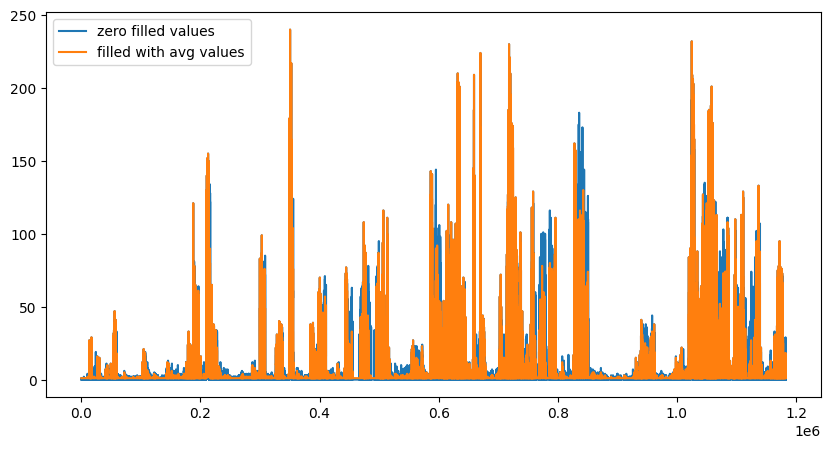

In [73]:
# 2020-01 10분 interval 탑승 빈도
plt.figure(figsize=(10, 5))
plt.plot(jan_2020_fill[0:1182960], label = "zero filled values")
plt.plot(jan_2020_smooth[0:1182960], label="filled with avg values")
plt.legend()
plt.show()

In [74]:
# Jan-2020 data is smoothed, Jan,Feb & March 2021 data missing values are filled with zero
jan_2020_smooth = smoothing(jan_2020_groupby['trip_distance'].values,jan_2020_unique)
jan_2021_smooth = fill_missing(jan_2021_groupby['trip_distance'].values,jan_2021_unique)
feb_2021_smooth = fill_missing(feb_2021_groupby['trip_distance'].values,feb_2021_unique)
mar_2021_smooth = fill_missing(mar_2021_groupby['trip_distance'].values,mar_2021_unique)

# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []

# a =[1,2,3]
# b = [2,3,4]
# a+b = [1, 2, 3, 2, 3, 4]

# number of 10min indices for jan 2020 = 24*31*60/10 = 4464
# number of 10min indices for jan 2021 = 24*31*60/10 = 4464
# number of 10min indices for feb 2021 = 24*29*60/10 = 4032
# number of 10min indices for march 2021 = 24*31*60/10 = 4464
# regions_cum: it will contain 265 lists, each list will contain 4464+4032+4464 values which represents the number of pickups 
# that are happened for three months in 2021 data

# i -> i-1, i+1 -> i
for i in range(1,266):
    regions_cum.append(jan_2021_smooth[4464*(i-1):4464*i]+feb_2021_smooth[4032*(i-1):4032*i]+mar_2021_smooth[4464*(i-1):4464*i])

# print(len(regions_cum))
# 265
# print(len(regions_cum[0]))
# 12960

In [75]:
print(len(regions_cum))
# 265
print(len(regions_cum[0]))
# 12960

265
12960


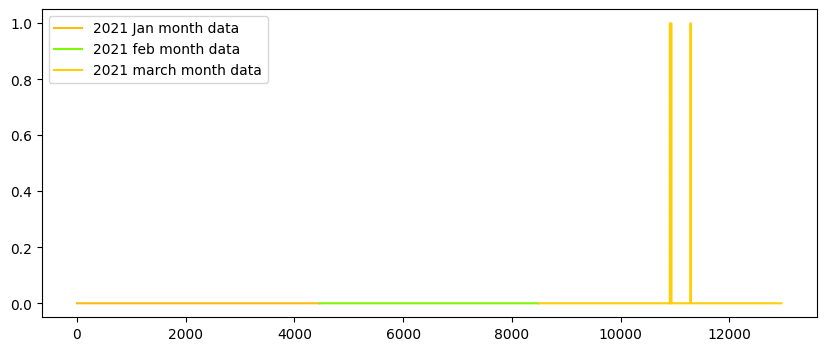

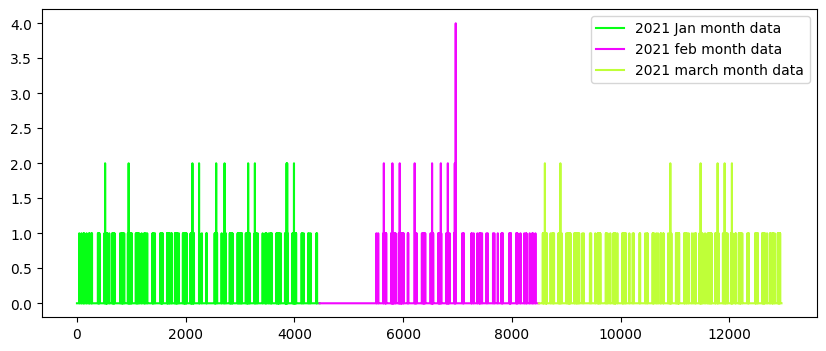

In [76]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
second_x = list(range(4464,8496))
third_x = list(range(8496,12960))
for i in range(1, 3):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regions_cum[i][:4464], color=uniqueish_color(), label='2021 Jan month data')
    plt.plot(second_x,regions_cum[i][4464:8496], color=uniqueish_color(), label='2021 feb month data')
    plt.plot(third_x,regions_cum[i][8496:], color=uniqueish_color(), label='2021 march month data')
    plt.legend()
    plt.show()

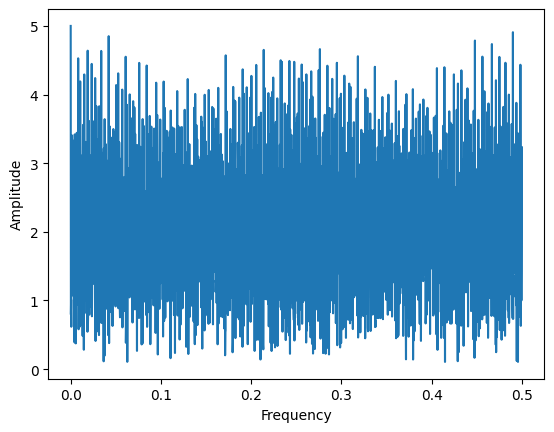

In [92]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(np.array(jan_2021_smooth)[0:4460])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4464, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [78]:
#Preparing the Dataframe only with x(i) values as jan-2020 data and y(i) values as jan-2021
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2020_smooth
ratios_jan['Prediction']=jan_2021_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

In [80]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*265):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [81]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*265):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [82]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*265):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [83]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*265):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [84]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*265):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [85]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*265):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [86]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

In [87]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2021 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2021 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2021 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.7080152542283445       MSE:  20.166954926624737
Moving Averages (2021 Values) -                        MAPE:  0.6412957199059538        MSE:  6.233370528166633
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.696266272068917       MSE:  21.525332217488334
Weighted Moving Averages (2021 Values) -               MAPE:  0.5718503855393896       MSE:  4.859137248934875
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.6979012998055908       MSE:  19.126516534794074
Exponential Moving Averages (2021 Values) -         MAPE:  0.56467857646298

In [123]:
# Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
# number of 10min indices for jan 2020= 24*31*60/10 = 4464
# number of 10min indices for jan 2021 = 24*31*60/10 = 4464
# number of 10min indices for feb 2021 = 24*28*60/10 = 4032
# number of 10min indices for march 2021 = 24*31*60/10 = 4464
# regions_cum: it will contain 265 lists, each list will contain 4464+4032+4464 values which represents the number of pickups 
# that are happened for three months in 2021 data

# print(len(regions_cum))
# 265
# print(len(regions_cum[0]))
# 12960

# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# output varaible
# it is list of lists
# it will contain number of pickups 12955 for each cluster
output = []

tsne_destination = []
# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 12955 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numbpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []

tsne_feature = [0]*number_of_time_stamps

for i in range(1,266):
    tsne_destination.append([i]*12955)
    # jan 1st 2021 is 금요일, so we start our day from 5: "(int(k/144))%7+5"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+5)%7) for k in range(5, 4464+4032+4464)])
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i-1][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i-1])-number_of_time_stamps)]))
    
    output.append(regions_cum[i-1][5:])
tsne_feature = tsne_feature[1:]

In [125]:
## 3433075
len(tsne_destination)*len(tsne_destination[0]) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 265*12955 == len(output)*len(output[0])

True

In [126]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(1,266):
    for i in range(0,12960):
        if i==0:
            predicted_value= regions_cum[r-1][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r-1][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [127]:
# train, test split : 70% 30% split
# Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region
print("size of train data :", int(12955*0.7))
print("size of test data :", int(12955*0.3))

size of train data : 9068
size of test data : 3886


In [128]:
# extracting first 9068 timestamp values i.e 70% of 12955 (total timestamps) for our training data
train_features =  [tsne_feature[(i-1)*12955:(12955*(i-1)+9068)] for i in range(1,266)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(12955*(i-1))+9068:12955*i] for i in range(1,266)]

In [129]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 265 Number of data points in trian data 9068 Each data point contains 5 features
Number of data clusters 265 Number of data points in test data 3887 Each data point contains 5 features


In [130]:
# extracting first 9169 timestamp values i.e 70% of 12955 (total timestamps) for our training data
tsne_train_flat_destination = [i[:9068] for i in tsne_destination]
tsne_train_flat_weekday = [i[:9068] for i in tsne_weekday]
tsne_train_flat_output = [i[:9068] for i in output]
tsne_train_flat_exp_avg = [i[:9068] for i in predict_list]

In [131]:
# extracting the rest of the timestamp values i.e 30% of 12955 (total timestamps) for our test data
tsne_test_flat_destination = [i[9068:] for i in tsne_destination]
tsne_test_flat_weekday = [i[9068:] for i in tsne_weekday]
tsne_test_flat_output = [i[9068:] for i in output]
tsne_test_flat_exp_avg = [i[9068:] for i in predict_list]

In [132]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(1,266):
    train_new_features.extend(train_features[i-1])
test_new_features = []
for i in range(1,266):
    test_new_features.extend(test_features[i-1])

In [133]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]
tsne_train_destination = sum(tsne_train_flat_destination, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [134]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]
tsne_test_destination = sum(tsne_test_flat_destination, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [135]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns)
df_train['destination'] = tsne_train_destination
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(2403020, 8)


In [136]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns)
df_test['destination'] = tsne_test_destination
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)

(1030055, 8)


In [137]:
df_test.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,destination,weekday,exp_avg
0,0,0,0,0,0,1,5,0
1,0,0,0,0,0,1,5,0
2,0,0,0,0,0,1,5,0
3,0,0,0,0,0,1,5,0
4,0,0,0,0,0,1,5,0


In [138]:
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# -------------------------
# default paramters
# sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

# some of methods of LinearRegression()
# fit(X, y[, sample_weight])	Fit linear model.
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict using the linear model
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# set_params(**params)	Set the parameters of this estimator.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1-2-copy-8/
# -----------------------

from sklearn.linear_model import LinearRegression
lr_reg=LinearRegression().fit(df_train, tsne_train_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

In [139]:
# Training a hyper-parameter tuned random forest regressor on our train data
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# -------------------------
# default paramters
# sklearn.ensemble.RandomForestRegressor(n_estimators=10, criterion=’mse’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False)

# some of methods of RandomForestRegressor()
# apply(X)	Apply trees in the forest to X, return leaf indices.
# decision_path(X)	Return the decision path in the forest
# fit(X, y[, sample_weight])	Build a forest of trees from the training set (X, y).
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict regression target for X.
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

In [140]:
# Predicting on test data using our trained random forest model 

# the models regr1 is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

In [141]:
#feature importances based on analysis using random forest
print (df_train.columns)
print (regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'destination', 'weekday',
       'exp_avg'],
      dtype='object')
[0.06821064 0.11451262 0.15108634 0.14792617 0.17051151 0.02644347
 0.00998838 0.31132087]


# Using XGBoost

In [142]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBRegressor function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#module-xgboost.sklearn
# -------------------------
# default paramters
# xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', 
# booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, 
# colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, 
# missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(df_train, tsne_train_output)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=200, ...)

In [143]:
#predicting with our trained Xg-Boost regressor
# the models x_model is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

In [144]:
#feature importances
x_model.get_booster().get_score(importance_type='weight')

{'ft_5': 871.0,
 'ft_4': 820.0,
 'ft_3': 865.0,
 'ft_2': 892.0,
 'ft_1': 850.0,
 'destination': 1312.0,
 'weekday': 330.0,
 'exp_avg': 869.0}

In [145]:
train_mape=[]
test_mape=[]

train_mape.append((mean_absolute_error(tsne_train_output,df_train['ft_1'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,rndf_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output, df_test['ft_1'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [146]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.5977300258998208       Test:  0.5894406213893693
Exponential Averages Forecasting -           Train:  0.5251863291183795       Test:  0.5259881560828702
Linear Regression -                         Train:  0.5059319535739113       Test:  0.5081671756863679
Random Forest Regression -                   Train:  0.431373541118532      Test:  0.511302753018929


In [147]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[4],"      Test: ",test_mape[4])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])
print ("XgBoost Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("--------------------------------------------------------------------------------------------------------")

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.5977300258998208       Test:  0.5894406213893693
Exponential Averages Forecasting -           Train:  0.5251863291183795       Test:  0.5259881560828702
Linear Regression -                         Train:  0.5140791777760179       Test:  0.518316623231783
Random Forest Regression -                   Train:  0.431373541118532      Test:  0.511302753018929
XgBoost Regression -                         Train:  0.5059319535739113       Test:  0.5081671756863679
--------------------------------------------------------------------------------------------------------
